In [56]:
import sys
import os 

if 'freya' in os.uname().nodename:
    sys.path.append('/Users/sdbykov/work/self-supervised-halos/')
else:
    sys.path.append('/u/sdbykov/self-supervised-halos/')

Running on Freya
matplotlib settings set


In [57]:
import requests
import numpy as np
import h5py
from tqdm import tqdm
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from utils.tng import HaloInfo, subhalos_df, subhalos_mass_history
from utils.utils import data_path, res_path, set_mpl
set_mpl()


matplotlib settings set


In [58]:
histories_df = pd.DataFrame(subhalos_mass_history).T
histories_df.index.name = 'subhalo_id'

#make mass and snap as np.arrayy for each halo
histories_df['mass'] = histories_df['mass'].apply(np.array)
histories_df['snap'] = histories_df['snap'].apply(np.array)
histories_df['log_subhalomass'] = histories_df.apply(lambda x: np.log10(x['mass'][0]), axis=1)

# Exploratory analysis

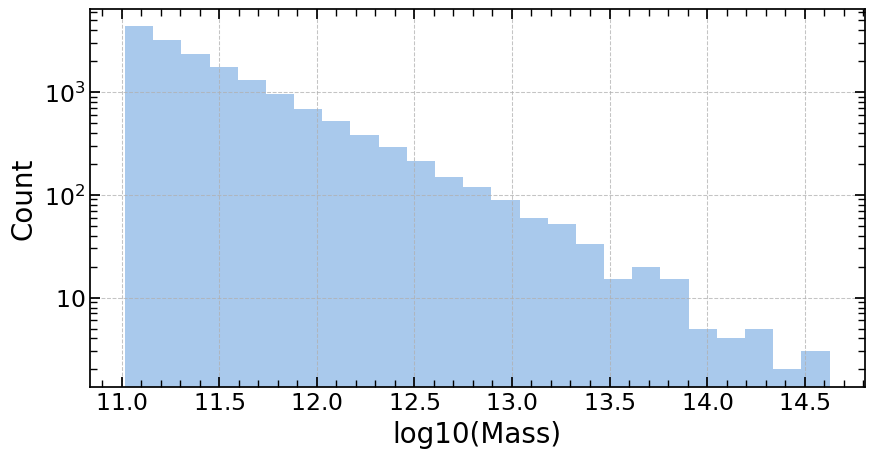

In [59]:
x = subhalos_df['logSubhaloMass']

plt.figure(figsize=(10, 5))
plt.hist(x, bins=25)
plt.yscale('log')
plt.xlabel('log10(Mass)')
plt.ylabel('Count')
plt.show()

In [60]:
plot_halos = True
if plot_halos:

    from utils.data.tng import HaloInfo
    from matplotlib.backends.backend_pdf import PdfPages

    n_to_plot = 20

    #set seed for reproducibility
    np.random.seed(111)
    #test_ids = subhalos_df.sample(n_to_plot).index
    #instead of random sample, split subhalos into 10 groups by log mass and take two from each group randomly
    subhalos_df['mass_group'] = pd.cut(subhalos_df['logSubhaloMass'], 10, labels=False)
    test_ids = []
    for i in range(10):
        group = subhalos_df[subhalos_df['mass_group']==i]
        test_ids.extend(group.sample(2).index)
        

    halo_dict = {}

    with PdfPages(res_path+'plots/halo_examples.pdf') as pdf:

        for i, id in enumerate(test_ids[::-1]):
            halo = HaloInfo(id)
            dens = halo.make_3d_density()
            fig, _ = halo.plot_all(dens, compact=True)

            pdf.savefig(fig)

            plt.close(fig)

            halo_dict[id] = halo


## Explore mass histories

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

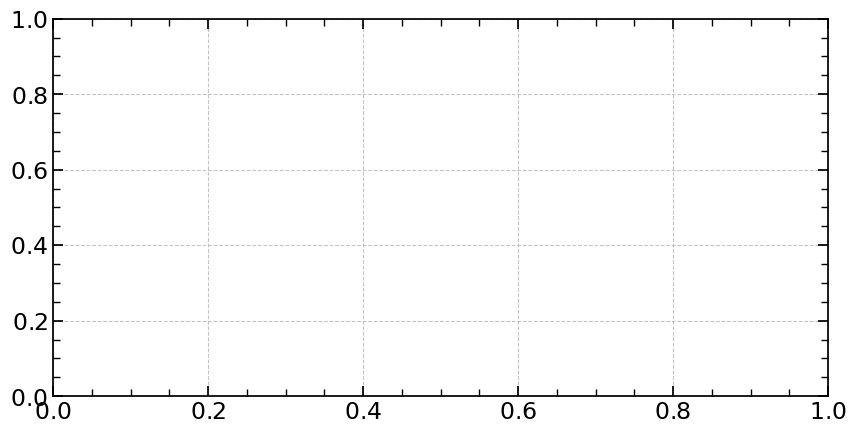

In [62]:
#make arrays of of each column
for col in histories_df.columns:
    histories_df[col] = histories_df[col].apply(lambda x: np.array(x))

histories_df['num_snap'] =  histories_df['snap'].apply(lambda x: len(x))
histories_df['min_snap'] =  histories_df['snap'].apply(lambda x: np.min(x))

plt.figure(figsize=(10, 5))
sns.histplot(histories_df['num_snap'], bins=25)
plt.yscale('log')

plt.figure(figsize=(10, 5))
sns.histplot(histories_df['min_snap'], bins=25)
plt.yscale('log')



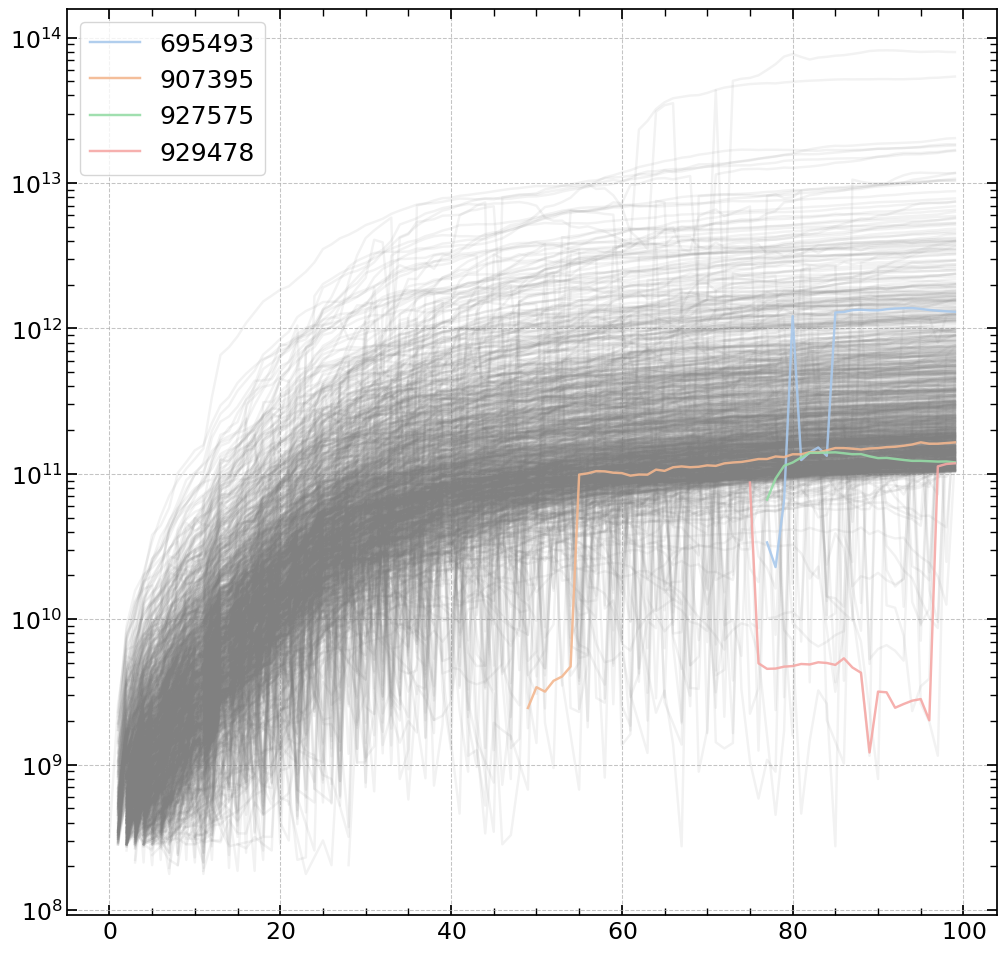

In [63]:
fig,  ax =  plt.subplots( figsize = (12,12))

for row in histories_df.sample(1000).index:
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.1, color = 'gray')


for row in histories_df.query('min_snap>70 | num_snap<60').index:
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.9, label=row)



ax.set_yscale('log')
ax.legend()



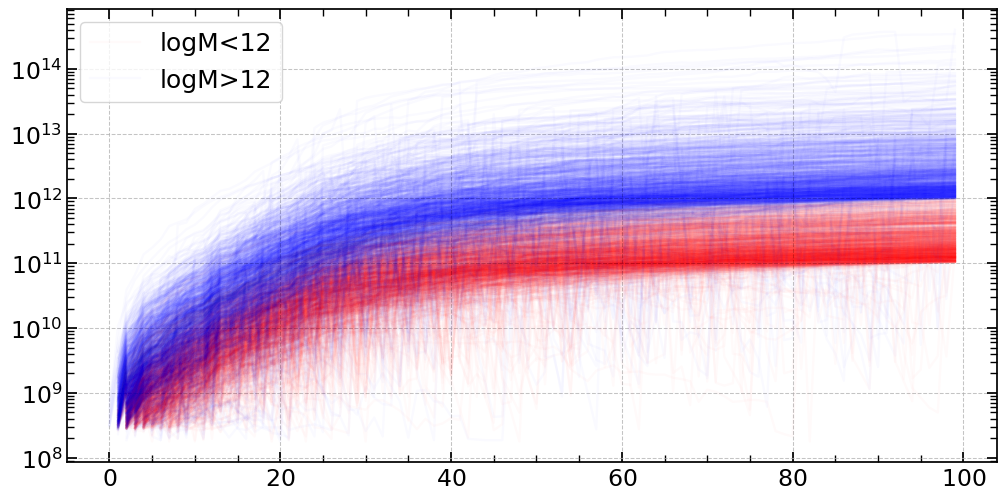

In [64]:
fig,  ax =  plt.subplots( figsize = (12,6))

for i, row in enumerate(histories_df.query('log_subhalomass<12').sample(1000).index):
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.02, color = 'red', label = 'logM<12' if i==0 else None)


for i, row in enumerate(histories_df.query('log_subhalomass>12').sample(1000).index):
    snap = histories_df.loc[row]['snap']
    mass = histories_df.loc[row]['mass']
    ax.plot(snap, mass, alpha=0.02, color = 'blue', label = 'logM>12' if i==0 else None)


ax.set_yscale('log')
ax.legend()




In [65]:
histories_df['mass_diff'] = histories_df['mass'].apply(lambda x: np.diff(x))
histories_df['mass_diff_neg_count'] = histories_df['mass_diff'].apply(lambda x: np.sum(x>0)) #>0 because snap is reversed


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

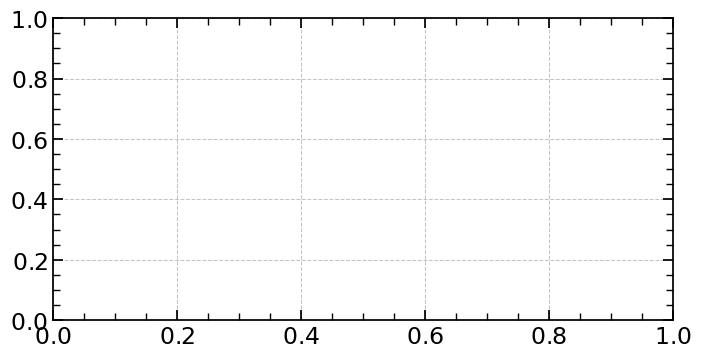

In [66]:
fig,  ax =  plt.subplots( figsize = (8,4))
sns.histplot(histories_df['mass_diff_neg_count'], bins=25, ax=ax)
ax.set_yscale('log')

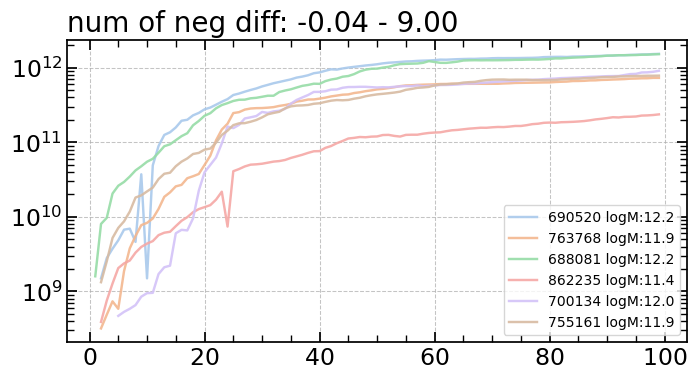

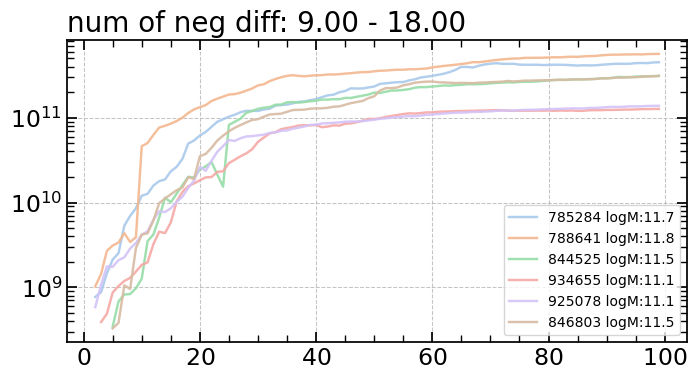

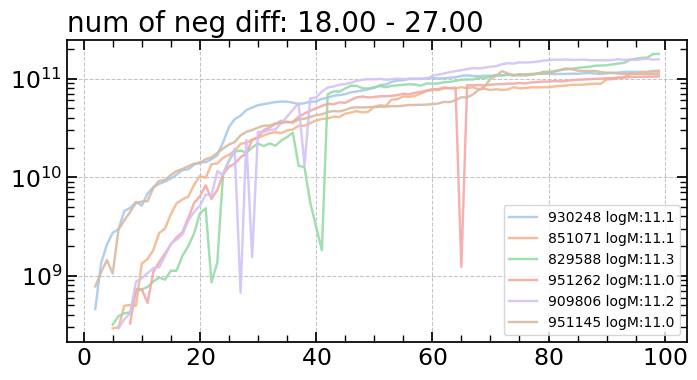

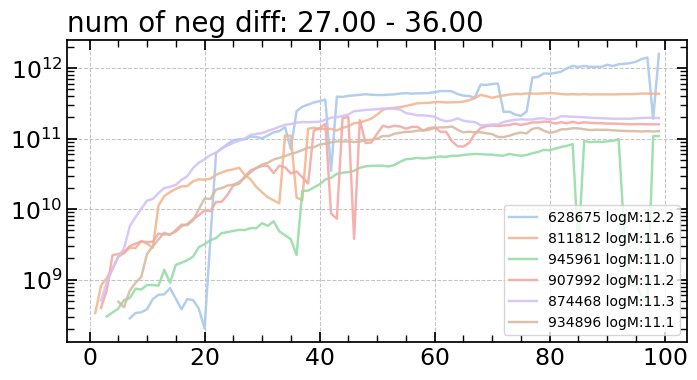

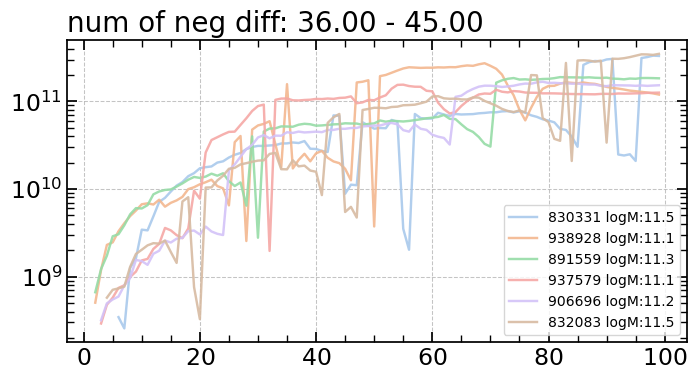

In [67]:
#bin in histories_df['mass_diff_neg_count'], 5 bins, and plot random 10 halos from each bin

cls, bins = pd.cut(histories_df['mass_diff_neg_count'], 5, labels=False, retbins=True)

n_sample = 6
for i in range(5):
    fig,  ax =  plt.subplots( figsize = (8,4))
    group = histories_df[cls==i]
    for j, row in enumerate(group.sample(n_sample).index) if len(group)>n_sample else enumerate(group.index):
        snap = histories_df.loc[row]['snap']
        mass = histories_df.loc[row]['mass']
        logmass = histories_df.loc[row]['log_subhalomass']
        ax.plot(snap, mass, alpha=0.9, label=str(row)+f' logM:{logmass:.1f}')

    gr_label = f'num of neg diff: {bins[i]:.2f} - {bins[i+1]:.2f}'
    ax.set_title(gr_label)
    ax.legend(fontsize = 10)
    ax.set_yscale('log')

## Explore images

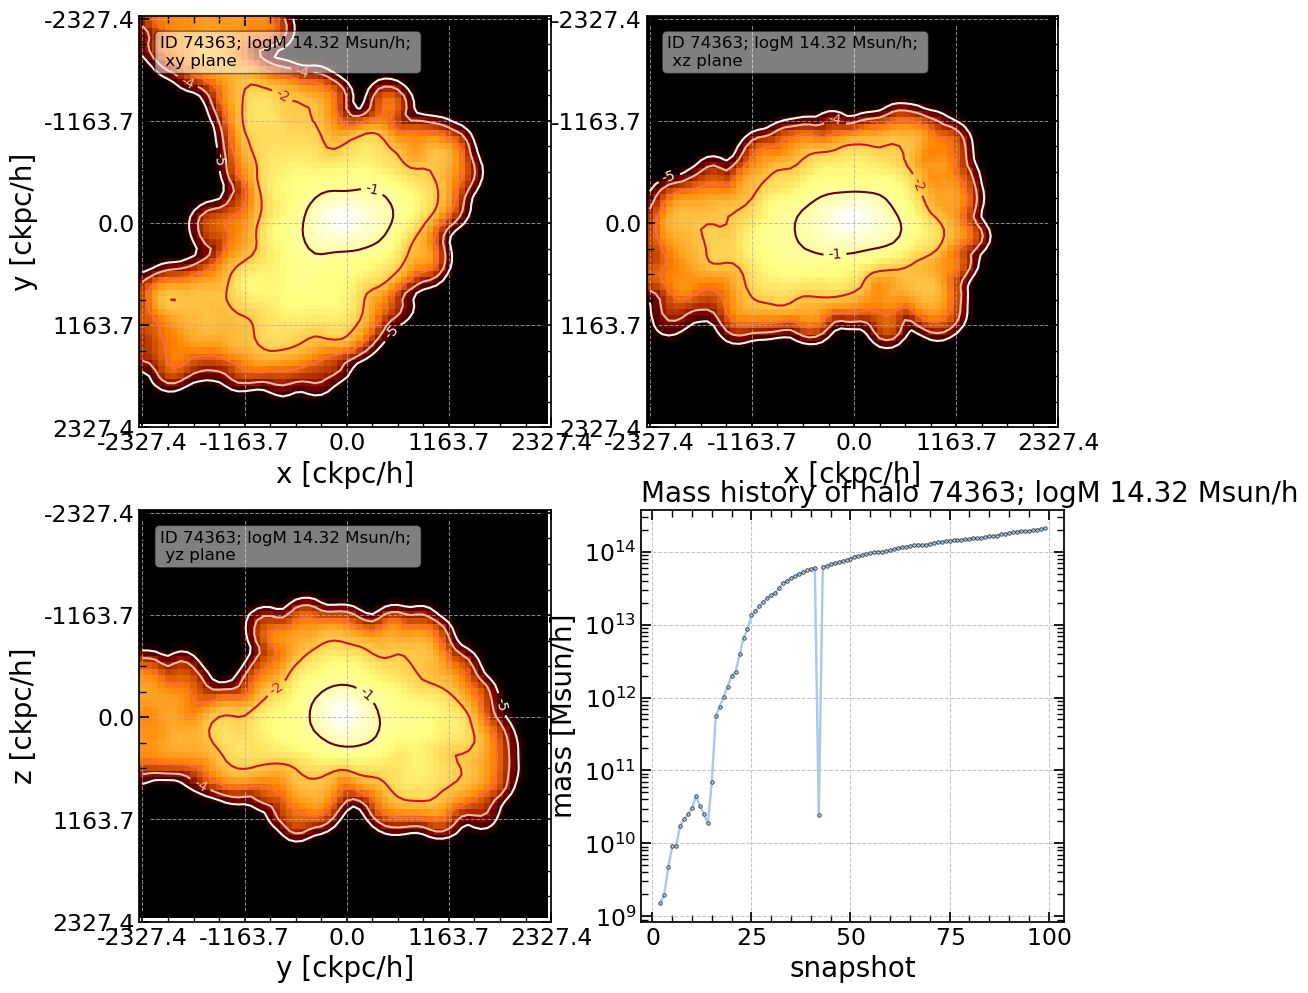

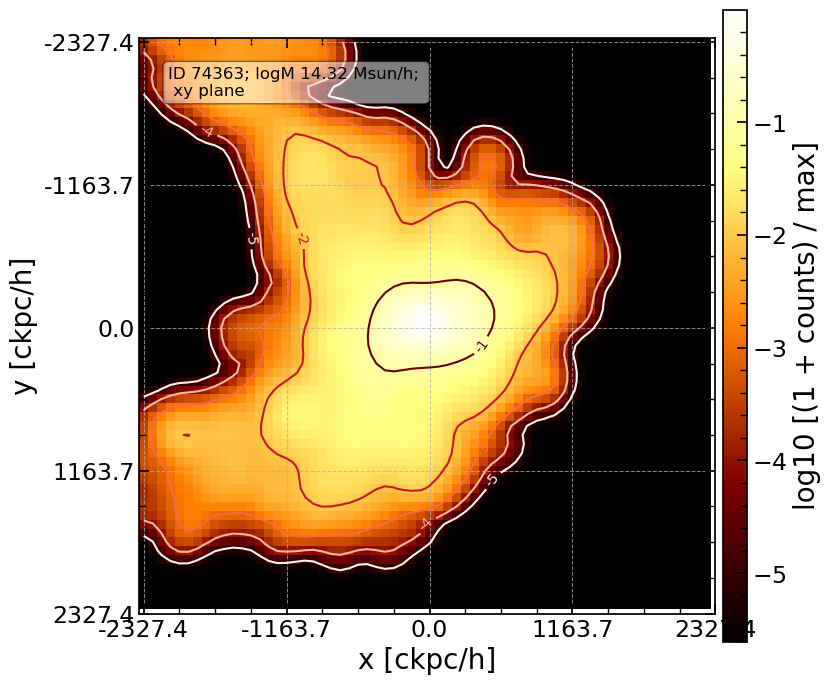

In [69]:
halo = HaloInfo(74363)
halo.plot_all(None);


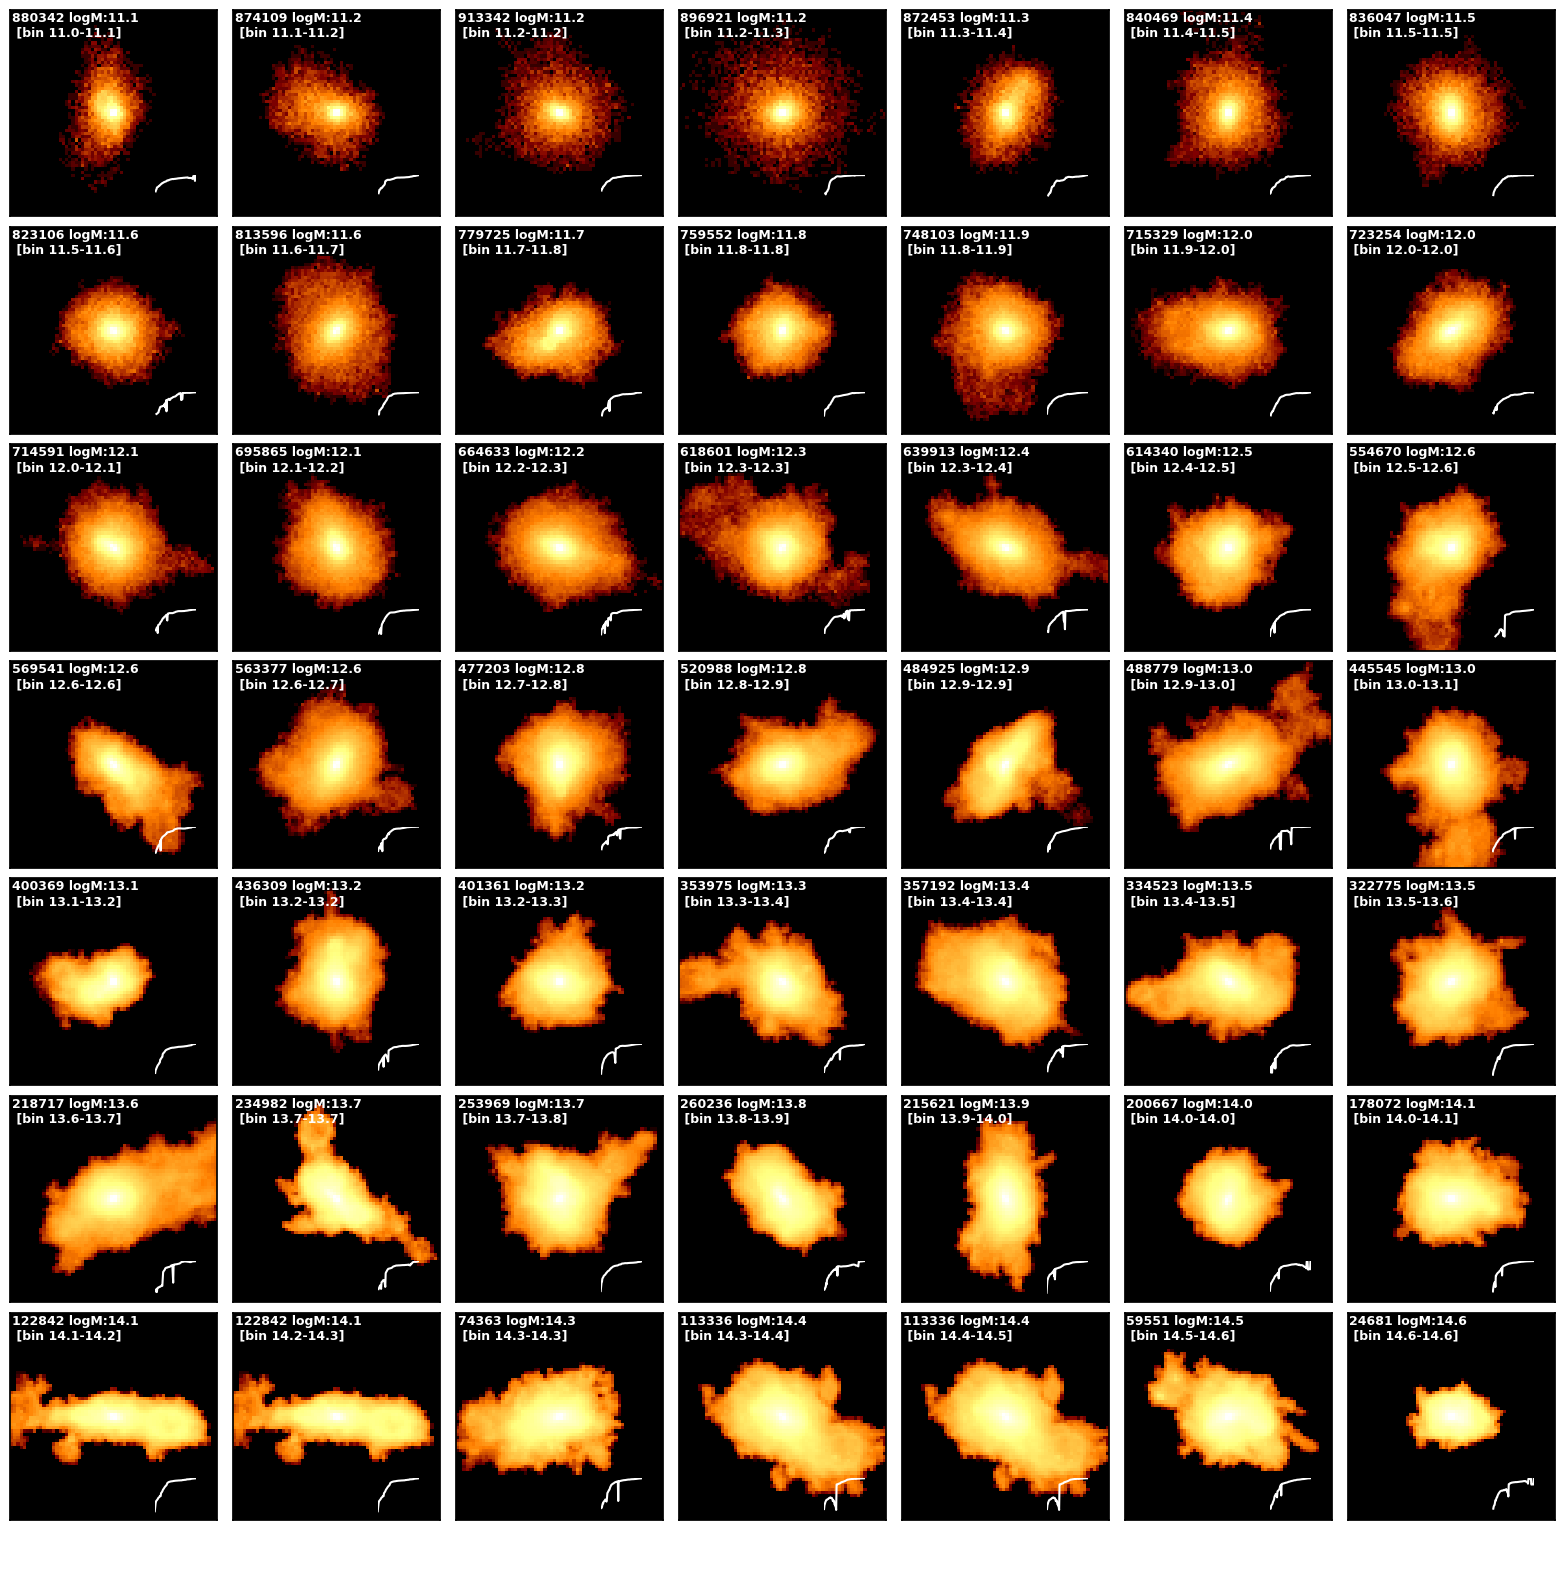

In [70]:
n_rows = 7
n_cols = n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

mass_cls, bins = pd.cut(subhalos_df['logSubhaloMass'], n_rows*n_cols, labels=False, retbins=True)

for i in range(n_rows):
    for j in range(n_cols):
        mass = bins[i*n_cols+j]
        mass_hi = bins[i*n_cols+j+1] if i*n_cols+j+1<len(bins) else 16

        subdf = subhalos_df.query(f'logSubhaloMass>{mass} & logSubhaloMass<{mass_hi}')
        if len(subdf)==0:
            haloid = haloid
        else:
            haloid = subdf.sample(1).index[0]
        
        halo = HaloInfo(haloid)

        halo.make_3d_density()
        orig_arr = halo.dens['projections']['xz']
        arr = 1+orig_arr
        arr = arr / np.max(arr)
        arr = np.log10(arr)


        mass_hist = histories_df.loc[halo.haloid]
        arr_mass = np.log10(mass_hist['mass'])/np.max(np.log10(mass_hist['mass']))
        arr_snap = mass_hist['snap']/99

        axes[i, j].imshow(arr, cmap='afmhot')

        #plot mass history as inset (transparent background white lines)
        inset = axes[i, j].inset_axes([0.7, -0.2, 0.2, 0.4], transform=axes[i, j].transAxes)
        inset.plot(arr_snap, arr_mass, color='white', lw=1.5)
        inset.set_xlim(0, 1)
        inset.set_ylim(0, 1)
        inset.axis('off')
        #make white border
        #inset.spines['bottom'].set_color('white')
        #inset.spines['top'].set_color('white')
        #inset.spines['right'].set_color('white')
        #inset.spines['left'].set_color('white')




        bin_left = bins[i*n_cols+j]
        bin_right = bins[i*n_cols+j+1] if i*n_cols+j+1<len(bins) else 16
        #axes[i, j].set_title(f'{bin_left:.1f}<M<{bin_right:.1f}')
        lbl = f'{halo.haloid} logM:{halo.mass_log_msun:.1f} \n [bin {bin_left:.1f}-{bin_right:.1f}]'
        axes[i, j].text(0, 0, lbl, color='white', fontsize=9, fontweight='bold', ha='left', va='top')


        #remove ticks and labels
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

#set space between subplots
#plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.savefig(res_path+'plots/halo_atlas.png')
plt.show()



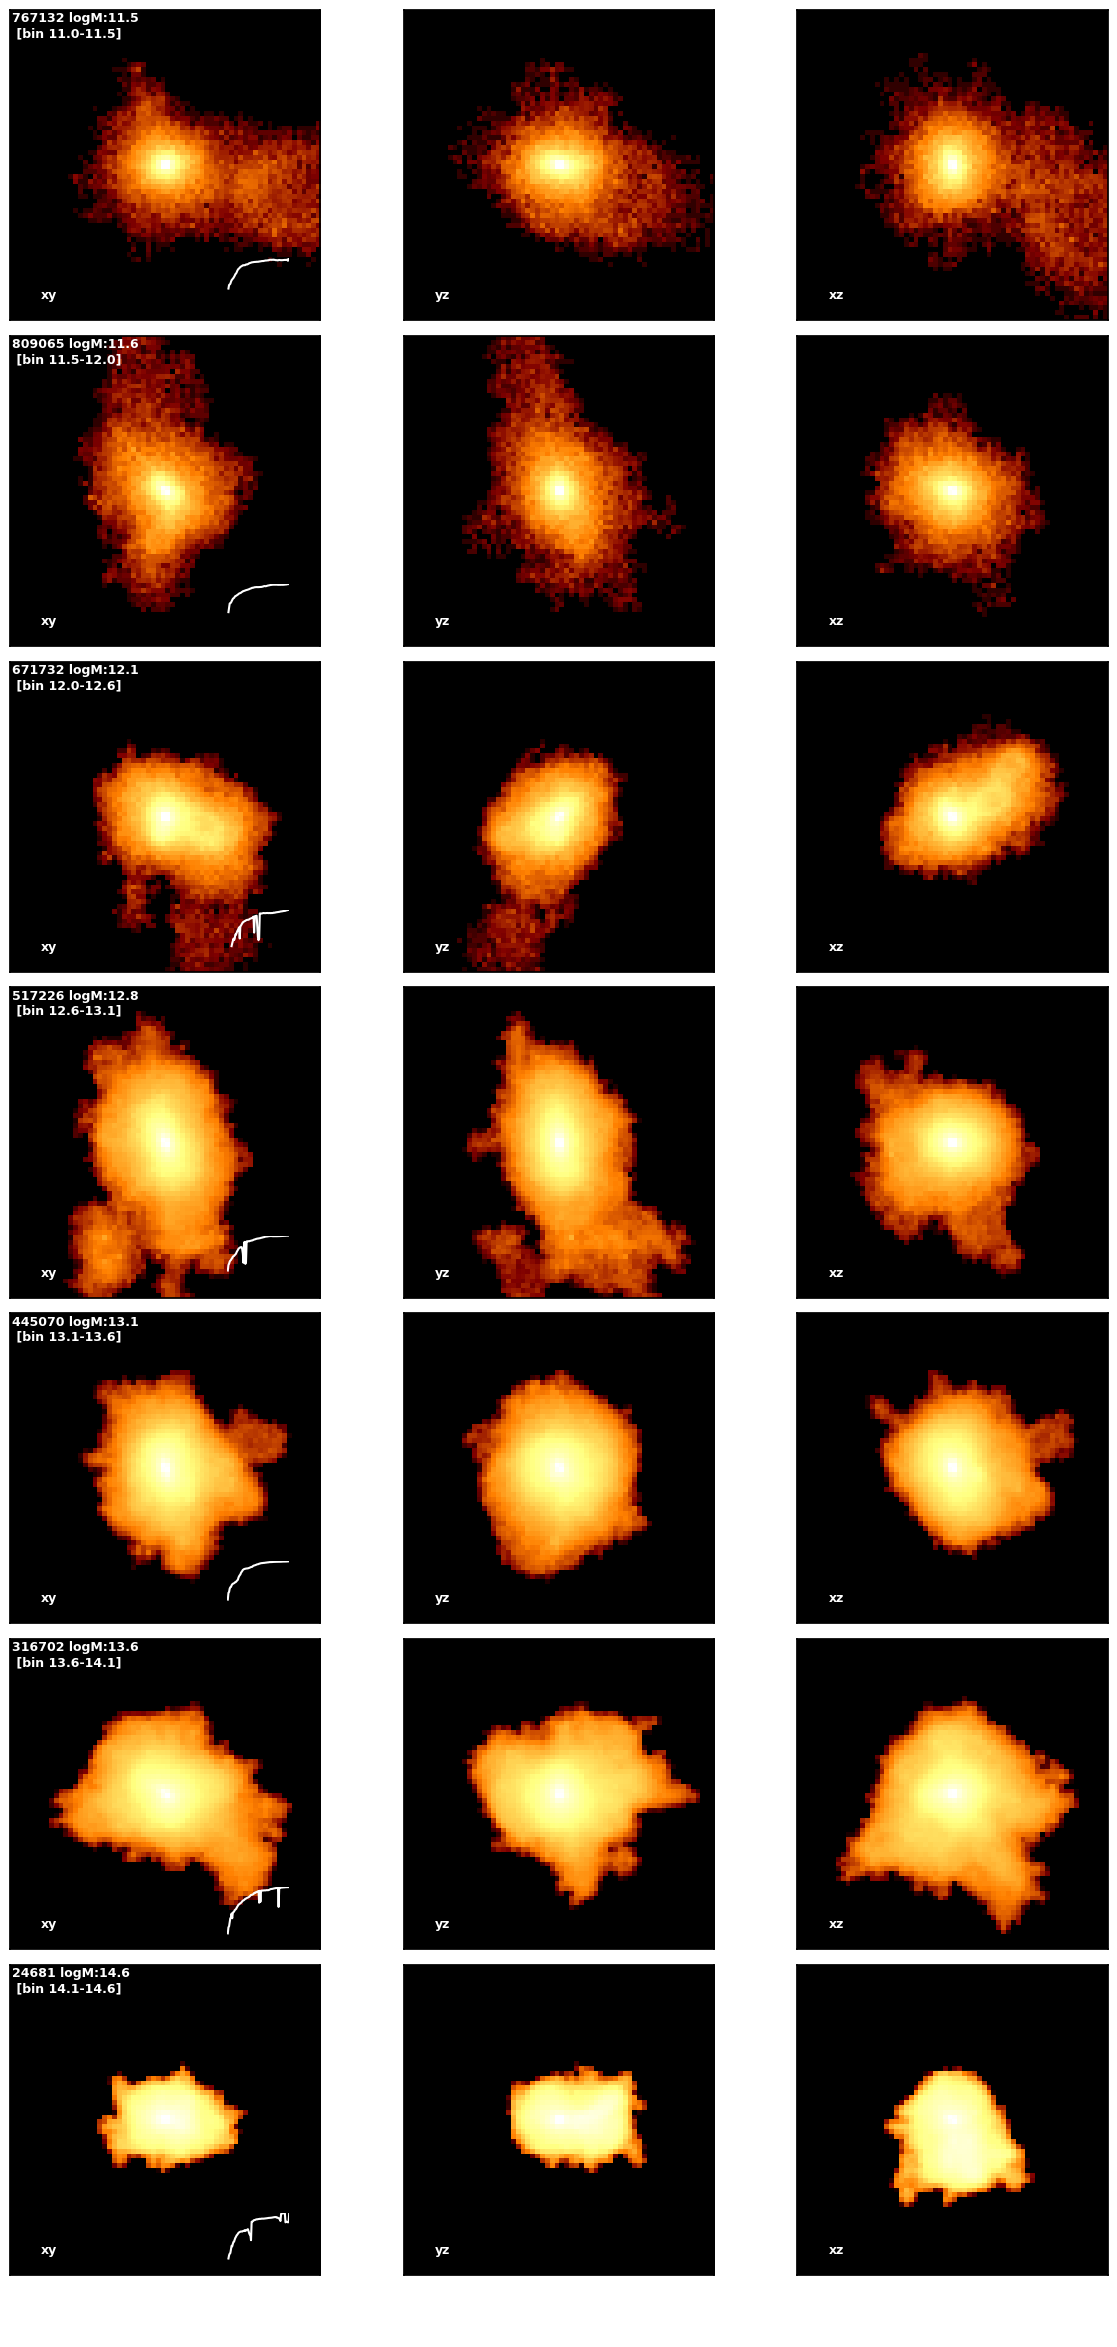

In [72]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize= (15, 30))

mass_cls, bins = pd.cut(subhalos_df['logSubhaloMass'], n_rows, labels=False, retbins=True)

for i in range(n_rows):
    mass = bins[i]
    mass_hi = bins[i+1] if i+1<len(bins) else 16

    subdf = subhalos_df.query(f'logSubhaloMass>{mass} & logSubhaloMass<{mass_hi}')
    if len(subdf)==0:
        haloid = haloid
    else:
        haloid = subdf.sample(1).index[0]

    halo = HaloInfo(haloid)
    halo.make_3d_density()
    arr_xz = halo.dens['projections']['xz']
    arr_yz = halo.dens['projections']['yz']
    arr_xy = halo.dens['projections']['xy']

    arr_xz = np.log10((1+arr_xz)/np.max(arr_xz+1))
    arr_yz = np.log10((1+arr_yz)/np.max(arr_yz+1))
    arr_xy = np.log10((1+arr_xy)/np.max(arr_xy+1))


    mass_hist = histories_df.loc[halo.haloid]
    arr_mass = np.log10(mass_hist['mass'])/np.max(np.log10(mass_hist['mass']))
    arr_snap = mass_hist['snap']/99

    axes[i, 0].imshow(arr_xz, cmap='afmhot')
    axes[i, 1].imshow(arr_yz, cmap='afmhot')
    axes[i, 2].imshow(arr_xy, cmap='afmhot')

    #plot mass history as inset (transparent background white lines)
    inset = axes[i, 0].inset_axes([0.7, -0.2, 0.2, 0.4], transform=axes[i, 0].transAxes)
    inset.plot(arr_snap, arr_mass, color='white', lw=1.5)
    inset.set_xlim(0, 1)
    inset.set_ylim(0, 1)
    inset.axis('off')
    #make white border
    #inset.spines['bottom'].set_color('white')
    #inset.spines['top'].set_color('white')
    #inset.spines['right'].set_color('white')
    #inset.spines['left'].set_color('white')




    #axes[i, j].set_title(f'{bin_left:.1f}<M<{bin_right:.1f}')
    lbl = f'{halo.haloid} logM:{halo.mass_log_msun:.1f} \n [bin {mass:.1f}-{mass_hi:.1f}]'
    axes[i, 0].text(0, 0, lbl, color='white', fontsize=9, fontweight='bold', ha='left', va='top')

    axes[i, 0].text(0.1, 0.1, 'xy', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 0].transAxes)
    axes[i, 1].text(0.1, 0.1, 'yz', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 1].transAxes)
    axes[i, 2].text(0.1, 0.1, 'xz', color='white', fontsize=9, fontweight='bold', ha='left', va='top', transform=axes[i, 2].transAxes)

    #remove ticks and labels
    for j in range(3):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

#set space between subplots
#plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(res_path+'plots/halo_atlas_projections.png')
plt.show()



(<Figure size 1200x1200 with 4 Axes>,
 array([[<AxesSubplot:xlabel='x [ckpc/h]', ylabel='y [ckpc/h]'>,
         <AxesSubplot:xlabel='x [ckpc/h]', ylabel='z [ckpc/h]'>],
        [<AxesSubplot:xlabel='y [ckpc/h]', ylabel='z [ckpc/h]'>,
         <AxesSubplot:title={'left':'Mass history of halo 0; logM 14.63 Msun/h'}, xlabel='snapshot', ylabel='mass [Msun/h]'>]],
       dtype=object))

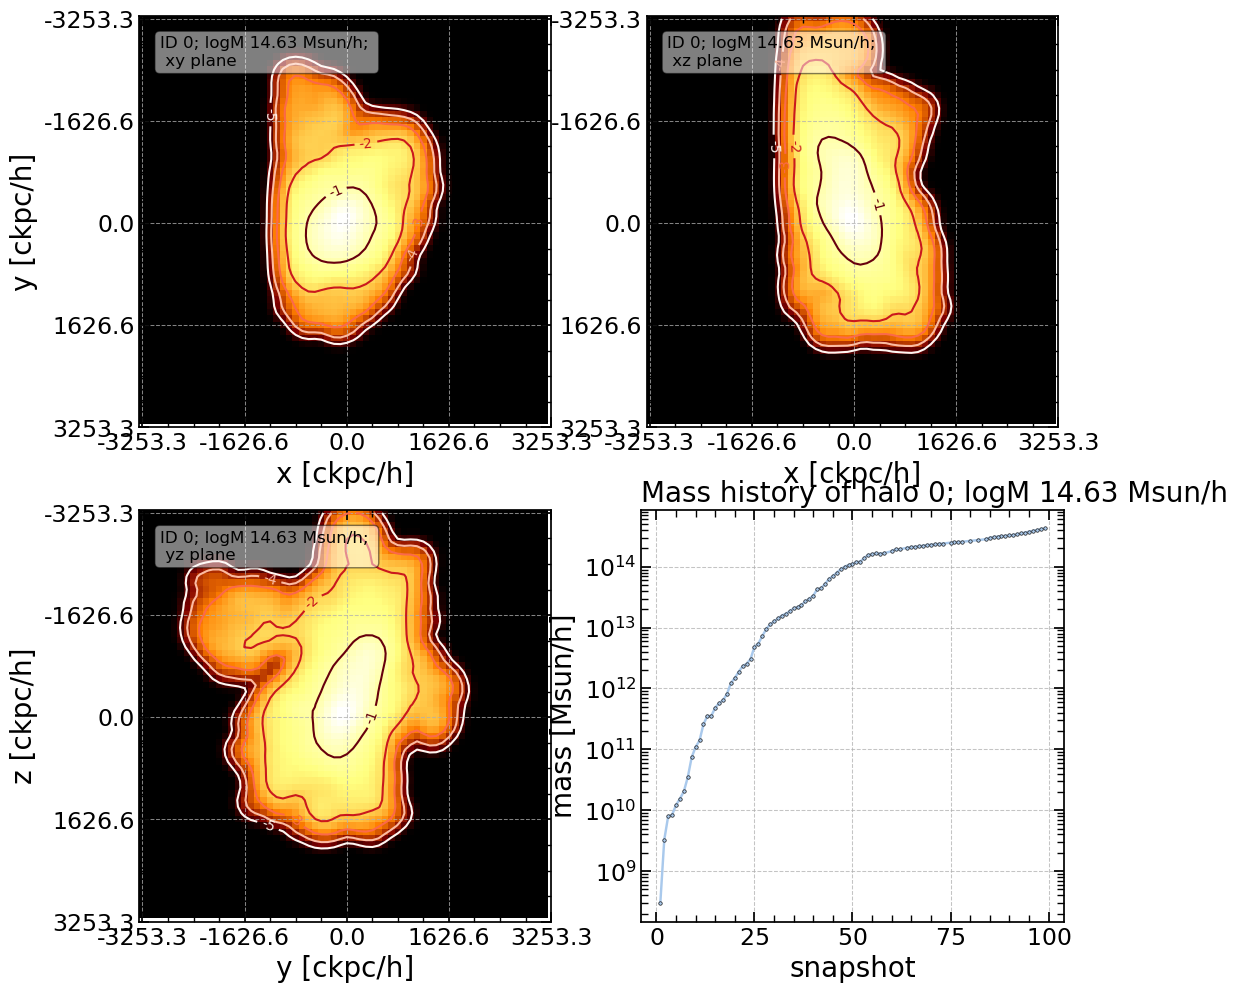

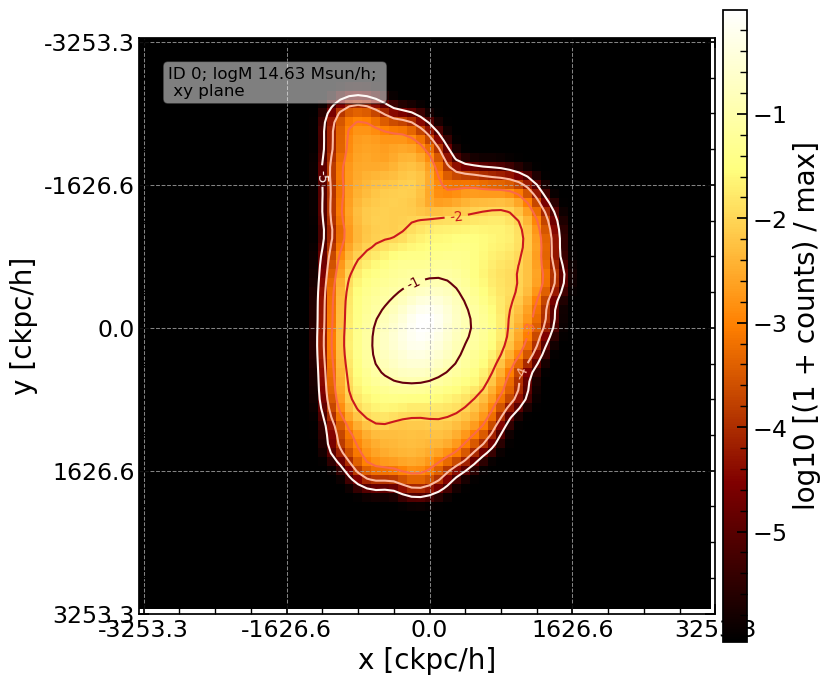

In [73]:
HaloInfo(0).plot_all(None)

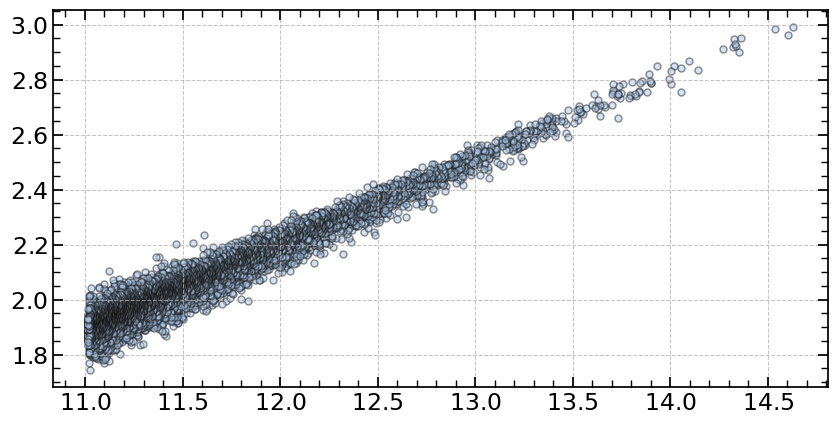

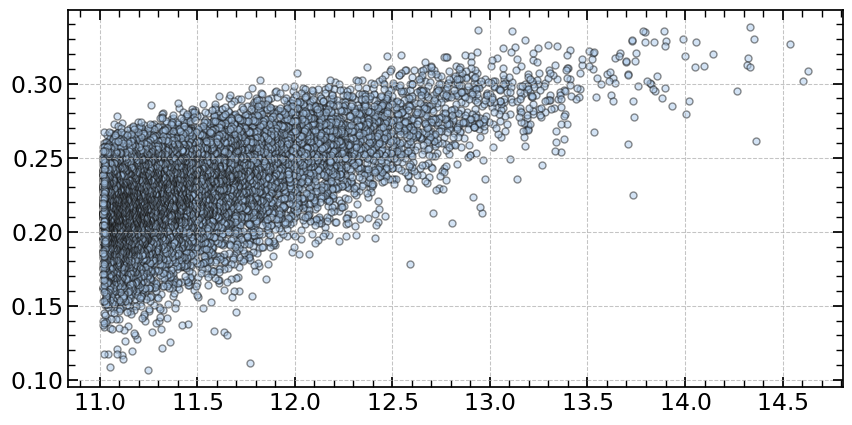

In [74]:
vd = np.log10(subhalos_df['SubhaloVmax'] )
m = subhalos_df['logSubhaloMass']

spins = subhalos_df['SubhaloSpin'].to_numpy()
#spins shape is a list of 3d vectors, make it 2d array
spins = np.array([x for x in spins])
spin_mag = np.linalg.norm(spins, axis=1)

spin_mag = np.log10(spin_mag)

plt.figure(figsize=(10, 5))
plt.scatter(m, vd, alpha=0.5)


plt.figure(figsize=(10, 5))
plt.scatter(m, spin_mag/m, alpha=0.5)

# prepare data for ML

In [54]:
raise ValueError('stop here')
postprocess_path = data_path+'/freya_postprocess/'
save_3d = True

for id in tqdm(subhalos_df.index): #3 min for saving without 3d data, 4 min for saving with 3d data. On freya: ~20 min saving with 3d (not srun but jupyter)
    halo = HaloInfo(id)
    halo.make_3d_density()
    data_transform = halo.data_transform(dens = None, smooth=None)

    map_2d_xz = data_transform['map_2d_xz']
    map_2d_yz = data_transform['map_2d_yz']
    map_2d_xy = data_transform['map_2d_xy']

    snap = data_transform['snapshot']
    mass_hist = data_transform['mass_hist']

    map_3d = data_transform['map_3d']
    
    
    fname_root_2d = f'{postprocess_path}/2d/halo_{id}_2d'
    fname_root_3d = f'{postprocess_path}/3d/halo_{id}_3d'
    fname_root_mass = f'{postprocess_path}/mass/halo_{id}_mass'

    np.savez(fname_root_2d, 
                map_2d_xz = map_2d_xz,
                map_2d_yz = map_2d_yz,
                map_2d_xy = map_2d_xy,
    )
    
    np.savez(fname_root_3d, 
                    map_3d = map_3d)

    np.savez(fname_root_mass,
                snap = snap,
                mass_hist = mass_hist
    )


  0%|          | 0/16544 [00:00<?, ?it/s]

100%|██████████| 16544/16544 [21:05<00:00, 13.07it/s]  


In [55]:
raise ValueError('stop here')
import shutil
shutil.make_archive(postprocess_path[:-1], 'zip', postprocess_path) # 10 min, approx 400 mb

'/freya/u/sdbykov/self-supervised-halos/data/freya_postprocess.zip'

-----